In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/ml_projects/ml_optimisation/"

Mounted at /content/gdrive


In [0]:
# enables inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
# imports the required packages
from fastai.collab import *
from fastai.tabular import *
from google.colab import files

In [6]:
# defines the data directory
data_dir = Path(root_dir + '/data/')
data_dir

PosixPath('/content/gdrive/My Drive/ml_projects/ml_optimisation/data')

In [99]:
# reads in the papers with code model data
model_data = pd.read_csv(data_dir/'pw_code_model_data.csv')

model_data.head()

,dataset,extradata,global_rank,metric_name,metric_value,model,remove,task,paper,paper_path,paper_url
0,IC15,NaN,# 10,F-Measure,75.61%,SegLink,-,Scene Text Detection,Detecting Oriented Text in Natural Images by L...,/paper/detecting-oriented-text-in-natural-imag...,NaN
1,SCUT-CTW1500,NaN,# 5,F-Measure,40.8%,SegLink,-,Curved Text Detection,Detecting Oriented Text in Natural Images by L...,/paper/detecting-oriented-text-in-natural-imag...,NaN
2,SNLI,NaN,# 36,% Test Accuracy,84.6,300D NSE encoders,-,Natural Language Inference,Neural Semantic Encoders,/paper/neural-semantic-encoders,NaN
3,SNLI,NaN,# 44,% Train Accuracy,86.2,300D NSE encoders,-,Natural Language Inference,Neural Semantic Encoders,/paper/neural-semantic-encoders,NaN
4,SNLI,NaN,# 1,Parameters,3.0m,300D NSE encoders,-,Natural Language Inference,Neural Semantic Encoders,/paper/neural-semantic-encoders,NaN


In [100]:
# remove all columns with NaN's
 model_data = model_data.dropna(axis=1, how='all')
  
 # drops the remove column
 model_data = model_data.drop('remove', 1)

# remove the hash from the global_rank column
model_data['global_rank'] = model_data['global_rank'].str.replace('#','')

# converts the global_rank column values to integers
model_data['global_rank'] = pd.to_numeric(model_data['global_rank'])

# remove rows where the metric_value is NaN
model_data = model_data.dropna(subset = ['metric_value'])

#
model_data = model_data[~model_data.metric_value.str.contains('-')]

len(model_data)

5425

In [0]:
model_data = model_data.loc[model_data['global_rank'] <= 5]

In [157]:
model_data.head()

,dataset,global_rank,metric_name,metric_value,model,task,paper,paper_path
1,SCUT-CTW1500,5,F-Measure,40.8%,SegLink,Curved Text Detection,Detecting Oriented Text in Natural Images by L...,/paper/detecting-oriented-text-in-natural-imag...
4,SNLI,1,Parameters,3.0m,300D NSE encoders,Natural Language Inference,Neural Semantic Encoders,/paper/neural-semantic-encoders
7,SNLI,1,Parameters,3.2m,300D MMA-NSE encoders with attention,Natural Language Inference,Neural Semantic Encoders,/paper/neural-semantic-encoders
12,VQA v2,2,Accuracy,70.24%,Pythia v0.1,Visual Question Answering,Pythia v0.1: the Winning Entry to the VQA Chal...,/paper/pythia-v01-the-winning-entry-to-the-vqa
13,ImageNet 128x128,3,FID,9.6,BigGAN,Conditional Image Generation,Large Scale GAN Training for High Fidelity Nat...,/paper/large-scale-gan-training-for-high-fidelity


In [158]:
#
dataset_uniq = model_data.dataset.unique()

# creates a dataset_ids dataframe   
dataset_ids = pd.DataFrame(dataset_uniq, columns=['dataset'])

# adds a dataset id for each dataset
dataset_ids['dataset_id'] = dataset_ids.index + 1

dataset_ids.head()

# user2idx = {o:i for i,o in enumerate(u_uniq)}
# # Take every unique user id and map it to a contiguous user .
# ratings.userId = ratings.userId.apply(lambda x: user2idx[x])
# # Replace that userid with contiguous number.

,dataset,dataset_id
0,SCUT-CTW1500,1
1,SNLI,2
2,VQA v2,3
3,ImageNet 128x128,4
4,BUCC French-to-English,5


In [159]:
#
model_uniq = model_data.model.unique()

# creates a model_ids dataframe   
model_ids = pd.DataFrame(model_uniq, columns=['model'])

# adds a model id for each dataset
model_ids['model_id'] = model_ids.index + 1

model_ids.head()

,model,model_id
0,SegLink,1
1,300D NSE encoders,2
2,300D MMA-NSE encoders with attention,3
3,Pythia v0.1,4
4,BigGAN,5


In [160]:
#
task_uniq = model_data.task.unique()

# creates a model_ids dataframe   
task_ids = pd.DataFrame(task_uniq, columns=['task'])

# adds a model id for each dataset
task_ids['task_id'] = task_ids.index + 1

task_ids.head()

,task,task_id
0,Curved Text Detection,1
1,Natural Language Inference,2
2,Visual Question Answering,3
3,Conditional Image Generation,4
4,Cross-Lingual Bitext Mining,5


In [161]:
#
training_data_raw = model_data[['dataset', 'task', 'model', 'global_rank']]

training_data_raw.head()

,dataset,task,model,global_rank
1,SCUT-CTW1500,Curved Text Detection,SegLink,5
4,SNLI,Natural Language Inference,300D NSE encoders,1
7,SNLI,Natural Language Inference,300D MMA-NSE encoders with attention,1
12,VQA v2,Visual Question Answering,Pythia v0.1,2
13,ImageNet 128x128,Conditional Image Generation,BigGAN,3


In [162]:
#
training_data = pd.merge(training_data_raw, model_ids, on='model')

training_data.head()

,dataset,task,model,global_rank,model_id
0,SCUT-CTW1500,Curved Text Detection,SegLink,5,1
1,SNLI,Natural Language Inference,300D NSE encoders,1,2
2,SNLI,Natural Language Inference,300D MMA-NSE encoders with attention,1,3
3,VQA v2,Visual Question Answering,Pythia v0.1,2,4
4,ImageNet 128x128,Conditional Image Generation,BigGAN,3,5


In [163]:
#
training_data = pd.merge(training_data, dataset_ids, on='dataset')

training_data.head()

,dataset,task,model,global_rank,model_id,dataset_id
0,SCUT-CTW1500,Curved Text Detection,SegLink,5,1,1
1,SCUT-CTW1500,Curved Text Detection,PSENet-1s,1,136,1
2,SCUT-CTW1500,Curved Text Detection,EAST,4,631,1
3,SCUT-CTW1500,Curved Text Detection,CTD+TLOC,3,983,1
4,SCUT-CTW1500,Curved Text Detection,SLPR,2,1211,1


In [164]:
#
#
training_data = pd.merge(training_data, task_ids, on='task')

training_data.head()

,dataset,task,model,global_rank,model_id,dataset_id,task_id
0,SCUT-CTW1500,Curved Text Detection,SegLink,5,1,1,1
1,SCUT-CTW1500,Curved Text Detection,PSENet-1s,1,136,1,1
2,SCUT-CTW1500,Curved Text Detection,EAST,4,631,1,1
3,SCUT-CTW1500,Curved Text Detection,CTD+TLOC,3,983,1,1
4,SCUT-CTW1500,Curved Text Detection,SLPR,2,1211,1,1


In [165]:
#
training_data = training_data[['dataset_id', 'model_id', 'global_rank', 'task_id', 'model']]

training_data.head()

,dataset_id,model_id,global_rank,task_id,model
0,1,1,5,1,SegLink
1,1,136,1,1,PSENet-1s
2,1,631,4,1,EAST
3,1,983,3,1,CTD+TLOC
4,1,1211,2,1,SLPR


In [0]:
#
model = 'model'

data = CollabDataBunch.from_df(training_data, 
                               seed=42, 
                               valid_pct = 0.1,
                               user_name = 'dataset_id',
                               item_name = 'model_id', 
                               rating_name = 'global_rank')


In [189]:
#
data.show_batch()

dataset_id,model_id,target
459,519,4.0
99,753,1.0
306,1265,1.0
155,120,5.0
158,439,5.0


In [190]:
#
training_data.global_rank.min(), training_data.global_rank.max()

(1, 5)

In [0]:
# learn = collab_learner(data, n_factors=40, y_range=(1, 5), wd=1e-15)

learn = collab_learner(data, n_factors=40, y_range=(1, 5))

In [222]:
learn.lr_find() # find learning rate

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.00E-01


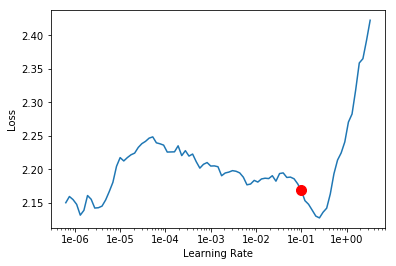

In [223]:
learn.recorder.plot(suggestion= True) # plot learning rate graph

In [266]:
#
learn.fit_one_cycle(1, 1e-01)

epoch,train_loss,valid_loss,time
0,1.220533,1.905452,00:00


In [267]:
learn.fit(20, 1e-01)

epoch,train_loss,valid_loss,time
0,1.160307,1.756259,00:00
1,0.896818,1.756897,00:00
2,0.732674,1.504654,00:00
3,0.649293,1.699075,00:00
4,0.598297,1.617249,00:00


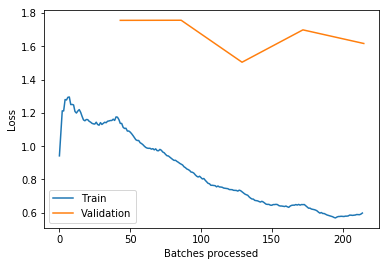

In [268]:
learn.recorder.plot_losses()

In [0]:
#
learn = collab_learner(data, ps=0.5, use_nn=True, emb_szs={'dataset_id': 20, 
                                                   'model_id': 20}, 
#                        layers=[256, 128],
                       layers = [200, 100],
                       y_range=(1, 5)
                      )

In [318]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.31E-07


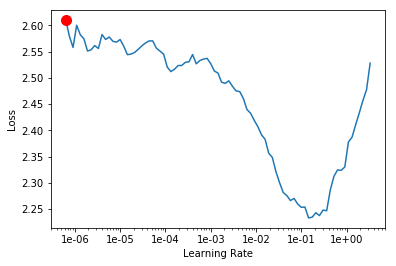

In [319]:
learn.recorder.plot(suggestion = True)

In [320]:
learn.fit_one_cycle(5, 2E-02)

epoch,train_loss,valid_loss,time
0,2.032085,1.897430,00:00
1,1.516250,1.635255,00:00
2,1.160602,1.605423,00:00
3,0.900314,1.564354,00:00
4,0.738523,1.567592,00:00


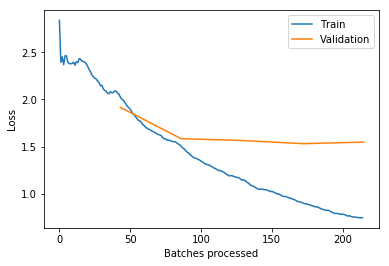

In [314]:
learn.recorder.plot_losses()

In [315]:
learn.fit_one_cycle(10, 9E-07)

epoch,train_loss,valid_loss,time
0,0.578053,1.541080,00:00
1,0.610265,1.550517,00:00
2,0.611611,1.550969,00:00
3,0.607935,1.545611,00:00
4,0.610447,1.541112,00:00
5,0.610959,1.545289,00:00
6,0.610179,1.540781,00:00
7,0.606632,1.547864,00:00
8,0.607493,1.548485,00:00
9,0.615051,1.545801,00:00


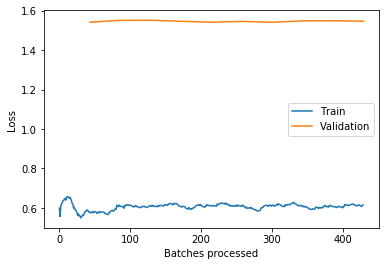

In [316]:
learn.recorder.plot_losses()

In [15]:
# extracts the integer from the metric_value column
model_data['metric_value'] = model_data['metric_value'].str.extract('(\d+)').astype(int)

model_data.head()

,dataset,global_rank,metric_name,metric_value,model,task,paper,paper_path
0,IC15,10,F-Measure,75,SegLink,Scene Text Detection,Detecting Oriented Text in Natural Images by L...,/paper/detecting-oriented-text-in-natural-imag...
1,SCUT-CTW1500,5,F-Measure,40,SegLink,Curved Text Detection,Detecting Oriented Text in Natural Images by L...,/paper/detecting-oriented-text-in-natural-imag...
2,SNLI,36,% Test Accuracy,84,300D NSE encoders,Natural Language Inference,Neural Semantic Encoders,/paper/neural-semantic-encoders
3,SNLI,44,% Train Accuracy,86,300D NSE encoders,Natural Language Inference,Neural Semantic Encoders,/paper/neural-semantic-encoders
4,SNLI,1,Parameters,3,300D NSE encoders,Natural Language Inference,Neural Semantic Encoders,/paper/neural-semantic-encoders
